In [55]:
import os
os.environ['PYSYN_CDBS']
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
plt.ion()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import synphot as S

from scipy.fftpack import fft,fftfreq
from scipy.signal import fftconvolve
from scipy.special import j1
from numpy import pi,sin,cos,sqrt


from astropy.convolution import Gaussian1DKernel, convolve


In [2]:
irac1_bp = S.specio.read_ascii_spec('/Users/vs522/Dropbox/Python/pysyn/cdbs/comp/nonhst/080924ch1trans_full.txt', wave_unit='micron', flux_unit='transmission')

irac2_bp = S.specio.read_ascii_spec('/Users/vs522/Dropbox/Python/pysyn/cdbs/comp/nonhst/080924ch2trans_full.txt', wave_unit='micron', flux_unit='transmission')

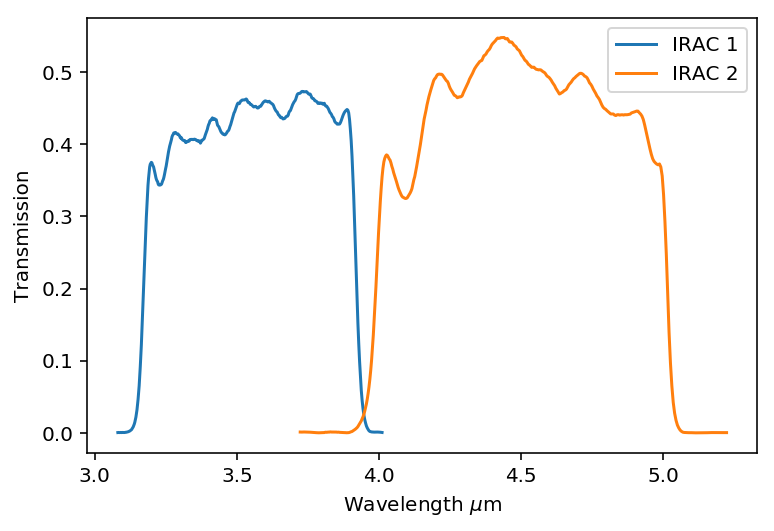

In [3]:
plt.plot(irac1_bp[1], irac1_bp[2], label='IRAC 1')
plt.plot(irac2_bp[1], irac2_bp[2], label='IRAC 2')
plt.xlabel('Wavelength $\mu$m')
plt.ylabel("Transmission")
plt.legend(loc='best')

### Synthetic spectrum - ATLAS9, MW metallicity, T$_{eff}$ = 4750, log g = 0.5

In [5]:
spec = S.specio.read_fits_spec('/Users/vs522/Dropbox/Python/pysyn/cdbs/grid/ck04models/ckp02/ckp02_4750.fits', flux_col='g05', flux_unit='flam')

(0, 50000)

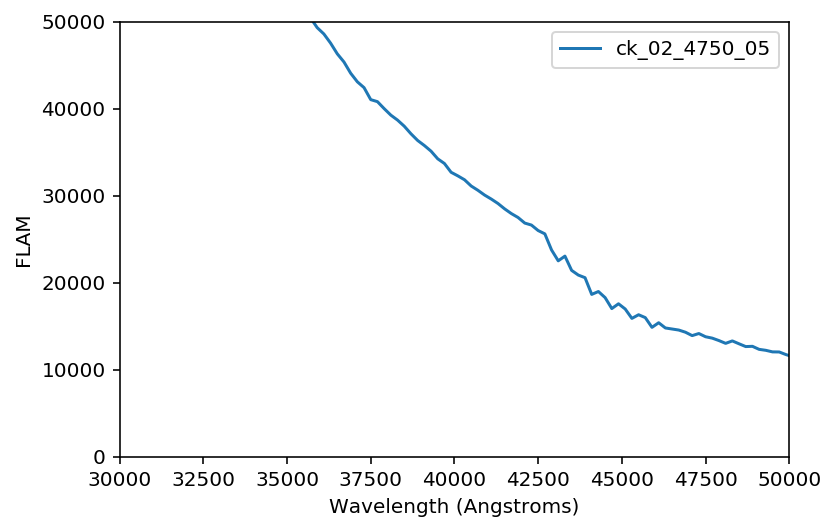

In [6]:
plt.plot(spec[1], spec[2], label='ck_02_4750_05')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("FLAM")
plt.legend(loc='best')
plt.xlim(30000,50000)
plt.ylim(0,50000)

In [57]:
lamrange = np.arange(3.0,5.0,0.05) ## wavelength range in microns

cc = 2.99792458e+18 # velocity of light in angstrom/s
epsilon = 0.6 # linear limbdarkening parameter



$$ \delta \lambda / \lambda  = v/c $$

$$ v = 25 km s^{-1} $$



In [74]:
v = 25e3
c = 3e8

dlam_lam = v / c

dlam_lam

8.333333333333333e-05

In [77]:
### at 4.5 um

dlam = dlam_lam * 4.5e-6
dlam

3.75e-10

### Define some constants

In [31]:
midwave = ((4.6e-6)/1e-10) # central wavelength of line
cc = 2.99792458e+18 # velocity of light in angstrom/s
epsilon = 0.6 # linear limbdarkening parameter
vsini = 25.*1e13 # input vsini in A/s (25 km/s)
dlam = 0.01 # spectrum resolution (A)
delta = midwave*vsini/cc

### Not adding noise

In [32]:
lambdas = np.linspace(-5,5,10./dlam+1) # wavelength interval
y = 1-(lambdas/delta)**2 # transformation of wavelengths
G = (2*(1-epsilon)*sqrt(y)+pi*epsilon/2.*y)/(pi*delta*(1-epsilon/3))#the kernel
print(G)

[ nan  nan  nan ...,  nan  nan  nan]


/Users/vs522/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.
/Users/vs522/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
keep = ~np.isnan(G) # returns boolean array with `False` where there are nans
lambdas,G = lambdas[keep],G[keep] # crop the arrays not to contain nans
lambdas.min(),lambdas.max()

(-3.8300000000000001, 3.8300000000000001)

In [34]:
3.8/midwave*(3e5)

24.782608695652172

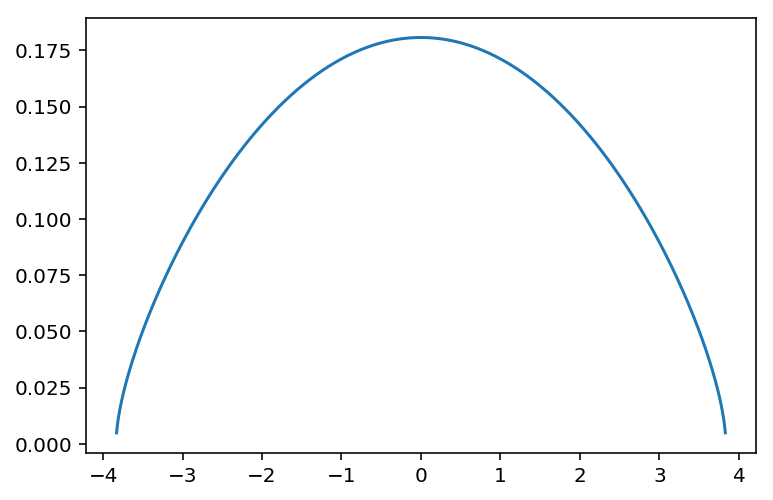

In [35]:
plt.plot(lambdas,G)


In [36]:
wavelengths = np.arange(midwave-5,midwave+5+dlam,dlam)
spec_line = 1-0.5*np.exp( -(wavelengths-midwave)**2/(2*0.1**2)) # width of 0.1A

In [37]:
spec_conv = fftconvolve(1-spec_line,G,mode='full')
N = len(spec_conv) # equals len(spec_line)+len(G)+1 when mode='full'
wavelengths_conv = np.arange(-N/2,N/2,1)*dlam + midwave
EW_before = np.trapz(1-spec_line,x=wavelengths) # trapezoidal integration
EW_after = np.trapz(spec_conv,x=wavelengths_conv)
spec_conv = 1-spec_conv/EW_after*EW_before

In [38]:
spec_obs = spec_conv + np.random.normal(size=len(spec_conv),scale=0.02)


(45499.99999999999, 46500.0)

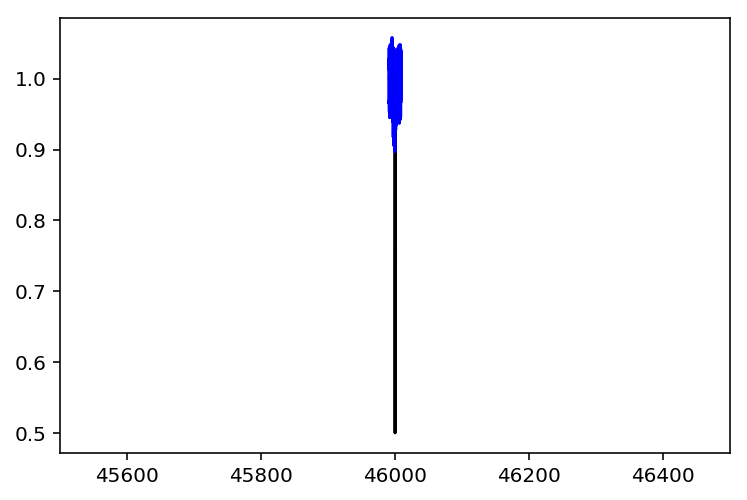

In [46]:
plt.figure(10);
plt.plot(wavelengths,spec_line,'k-');
plt.plot(wavelengths_conv,spec_conv,'r-');
plt.plot(wavelengths_conv,spec_obs,'b-');
plt.xlim(((4.55e-6)/1e-10),((4.65e-6)/1e-10))

In [19]:
wavelengths

array([ 4475.  ,  4475.01,  4475.02, ...,  4484.99,  4485.  ,  4485.01])

In [20]:
spec_line

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [21]:
spec

({'': 
  
  
  
  
  
  ,
  'BITPIX': 16,
  'COMMENT':   FITS (Flexible Image Transport System) format is defined in 'Astronomy
    and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H,
  'DATE': '2007-01-09T19:47:16',
  'EXTEND': True,
  'FILENAME': 'ckp02_4750.fits',
  'HISTORY':   File created by F.R.Boffi
    ATLAS9 model atmospheres by Castelli and Kurucz (2004).
    Wavelength is in Angstrom.
    Fluxes tabulated in units of erg/s/cm^2/A
    (after converting original units into "flam",
    as described in README file and the SYNPHOT manual)
    and are surface fluxes. To transform to observed
    fluxes multiply by (R/D)^2 where R is the
    radius of the star and D the distance.
    Each column in the table represents the
    spectrum of a star for the same metallicity
    and effective temperature but different gravity.
    Gravities range from log_g = +0.0 (g00 in the column
    header) to log_g = +5.0 (g50 in the column header).,
  'IRAF-TLM': '14:47:28 (09/

In [28]:
### apply to synthetic spectrum

spec_line_at = spec[2]
wavelengths_at = spec[1]

spec_conv = fftconvolve(spec_line_at,G,mode='full')
N = len(spec_conv) # equals len(spec_line)+len(G)+1 when mode='full'
wavelengths_conv = np.arange(-N/2,N/2,1)*dlam + midwave
EW_before = np.trapz(spec_line_at,x=wavelengths_at) # trapezoidal integration
EW_after = np.trapz(spec_conv,x=wavelengths_conv)
spec_conv = spec_conv/EW_after*EW_before

ValueError: x and y must have same first dimension, but have shapes (1295,) and (1076,)

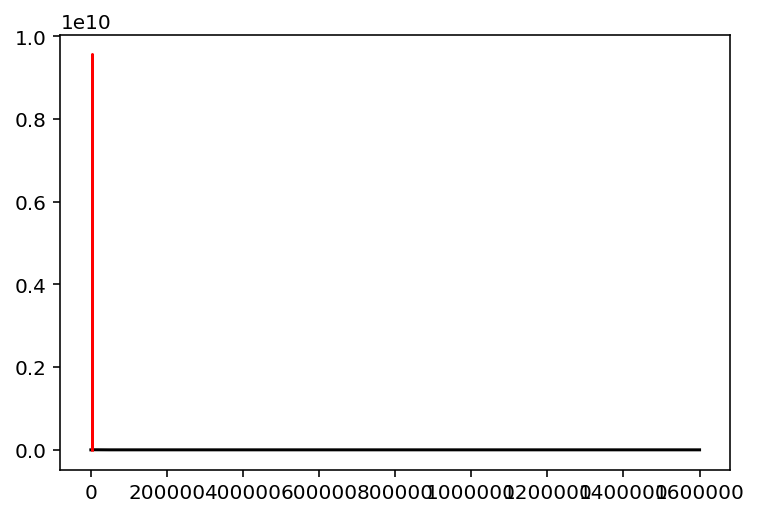

In [29]:
plt.figure(10);
plt.plot(wavelengths_at,spec_line_at,'k-');
plt.plot(wavelengths_conv,spec_conv,'r-');
plt.plot(wavelengths_conv,spec_obs,'b-');


In [48]:
G

array([ 0.00493926,  0.00838115,  0.01096259,  0.01316533,  0.01514025,
        0.01695826,  0.01865947,  0.02026919,  0.0218046 ,  0.023278  ,
        0.02469858,  0.02607337,  0.02740796,  0.0287068 ,  0.02997359,
        0.03121137,  0.03242271,  0.03360981,  0.03477455,  0.03591858,
        0.03704331,  0.03815001,  0.03923979,  0.04031366,  0.04137249,
        0.0424171 ,  0.04344821,  0.04446646,  0.04547247,  0.04646678,
        0.04744989,  0.04842226,  0.04938432,  0.05033645,  0.05127903,
        0.0522124 ,  0.05313685,  0.0540527 ,  0.05496021,  0.05585964,
        0.05675123,  0.05763521,  0.05851179,  0.05938118,  0.06024355,
        0.06109909,  0.06194796,  0.06279034,  0.06362636,  0.06445618,
        0.06527993,  0.06609773,  0.06690973,  0.06771602,  0.06851673,
        0.06931197,  0.07010183,  0.07088641,  0.07166582,  0.07244013,
        0.07320944,  0.07397382,  0.07473337,  0.07548815,  0.07623823,
        0.0769837 ,  0.07772461,  0.07846104,  0.07919304,  0.07

In [54]:
sp_G = S.SourceSpectrum(lambdas, G)

SynphotError: Redshift must be a real scalar number.